In [1]:
import sys
import os

# Insert the grandparent directory into sys.path
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
grandparent_dir = os.path.abspath(os.path.join(notebook_dir, "..", ".."))
sys.path.append(grandparent_dir)

In [2]:
from dotenv import load_dotenv
load_dotenv()  # This looks for .env in the current working directory

True

In [3]:
import time
from tqdm import tqdm

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    answer_correctness,
    context_recall,
    faithfulness
)

from langchain_core.messages import (
    HumanMessage, 
    ToolMessage, 
    AIMessage, 
    ToolMessage
)

from typing import Any, Tuple

/Users/tomazbratanic/anaconda3/envs/madafaka/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Benchmark data
test_df = pd.read_csv('benchmark.csv', delimiter=";")
test_df.head()

,question,ground_truth
0,What are some contracts that ended after 1990-...,I found 323 contracts that ended after 1990-01...
1,What are some contracts that ended after 1990-...,"There are 52 contracts classified as ""Strategi..."
2,"What are some contracts with HC2 Holdings, Inc.?","There is one contract involving HC2 Holdings, ..."
3,Which year was the most contracts signed?,The year with the most contracts signed was 20...
4,Which Hosting contracts have the highest total...,The Hosting contract with the highest total va...


In [5]:
from backend.agent import get_agent

In [6]:
def get_answer(agent: Any, input: str) -> Tuple[str, str, str]:
    input_messages = [HumanMessage(content=input)]
    messages = agent.invoke({"messages": input_messages})
    tools = [
        m.additional_kwargs.get("function_call")
        if m.additional_kwargs.get("function_call")
        else m.additional_kwargs.get("tool_calls")
        for m in messages["messages"]
        if isinstance(m, AIMessage)
        and (
            m.additional_kwargs.get("function_call")
            or m.additional_kwargs.get("tool_calls")
        )
    ]
    context = [m.content for m in messages["messages"] if isinstance(m, ToolMessage)]
    answer = messages["messages"][-1].content
    return answer, tools, context


In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI

llms = [
    ("gemini-1.5-pro", ChatGoogleGenerativeAI(model="gemini-1.5-pro",temperature=0)),
    ("gemini-2.0-flash", ChatGoogleGenerativeAI(model="gemini-2.0-flash",temperature=0)),
    ("gpt-4o", ChatOpenAI(model="gpt-4o", temperature=0))
]


In [8]:
# Get workflows generated answers
for llm in llms:
    print(f"Using LLM: {llm[0]}")
    results = []
    latencies = []
    agent = get_agent(llm[1])
    for i, row in tqdm(
        test_df.iterrows(), total=len(test_df), desc="Processing questions"
    ):
        question = row["question"]
        start = time.time()
        try:
            data = get_answer(agent, question)
        except Exception as e:
            print(e)
            data = {"answer": "timeout", "question": question}
        end = time.time()
        latencies.append(end - start)
        results.append(data)

    test_df[f"latencies_{llm[0]}"] = latencies
    test_df[f"response_{llm[0]}"] = [el[0] for el in results]
    test_df[f"tools_{llm[0]}"] = [el[1] for el in results]
    test_df[f"retrieved_contexts_{llm[0]}"] = [
        [str(item) for item in el[2]] for el in results
    ]


Using LLM: gemini-1.5-pro


Processing questions: 100%|██████████| 22/22 [01:02<00:00,  2.83s/it]


Using LLM: gemini-2.0-flash


Processing questions: 100%|██████████| 22/22 [00:32<00:00,  1.47s/it]


Using LLM: gpt-4o


Processing questions: 100%|██████████| 22/22 [03:08<00:00,  8.55s/it]


In [9]:
from ragas.metrics import AspectCritic

# you can init the metric with the evaluator llm
answer_satisfaction = AspectCritic(
    name="answer_satisfaction",
    definition="""You will evaluate an ANSWER to a legal QUESTION based on a provided SOLUTION.

Rate the answer on a scale from 0 to 1, where:
- 0 = incorrect, substantially incomplete, or misleading
- 1 = correct and sufficiently complete

Consider these evaluation criteria:
1. Factual correctness is paramount - the answer must not contradict the solution
2. The answer must address the core elements of the solution
3. Additional relevant information beyond the solution is acceptable and may enhance the answer
4. Technical legal terminology should be used appropriately if present in the solution
5. For quantitative legal analyses, accurate figures must be provided

### Examples:

QUESTION: What is the statute of limitations for breach of contract in California?
GROUND_TRUTH: In California, the statute of limitations for written contracts is 4 years, and for oral contracts is 2 years, as specified in California Code of Civil Procedure § 337 and § 339.
RESPONSE: California has a 4-year statute of limitations for written contract claims and 2 years for oral contracts.
RATING: 1

QUESTION: What is required for a valid contract?
GROUND_TRUTH: A valid contract requires offer, acceptance, consideration, legal capacity of the parties, legal purpose, and mutual assent (meeting of the minds).
RESPONSE: For a contract to be valid, there must be consideration exchanged between the parties.
RATING: 0

QUESTION: What contracts are governed by US law?
GROUND_TRUTH: There are 316 contracts governed by US law
RESPONSE: There are 316 contracts governed by US law. Here are a few examples:\n\n1. **Remarketing Agreement**:\n - **Parties**: Nuveen AMT-Free Municipal Credit Income Fund, Nuveen Fund Advisors, LLC, and a Remarketing Agent.\n - **Type**: Service\n - **Scope**: Remarketing of Series MuniFund Preferred Shares.\n - **Effective Date**: January 1, 2024\n\n2. **Joint Filing Agreement**:\n - **Parties**: Multiple parties including Athene Annuity and Life Company, Apollo Insurance Solutions Group...	
RATING: 1

QUESTION: What is the total monetary value of all contracts with WebMD, Inc.?
GROUND_TRUTH: The total monetary value of all contracts with WebMD, Inc. is $5,000.	
RESPONSE: There is only one contract involving WebMD, Inc., which is a Content License Agreement with Emdeon Corporation. This agreement allows Emdeon to use WebMD's anatomical line drawings in its software and the value is 5000
RATINGL 1""",
)

In [10]:
# For Gemini-1.5-pro
df_gemini_1_5 = test_df[['question', 'ground_truth', 'response_gemini-1.5-pro', 'retrieved_contexts_gemini-1.5-pro']].copy()
df_gemini_1_5 = df_gemini_1_5.rename(columns={'response_gemini-1.5-pro': 'answer'})
df_gemini_1_5 = df_gemini_1_5.rename(columns={'retrieved_contexts_gemini-1.5-pro': 'retrieved_contexts'})

# For Gemini-2.0-flash
df_gemini_2_0 = test_df[['question', 'ground_truth', 'response_gemini-2.0-flash', 'retrieved_contexts_gemini-2.0-flash']].copy()
df_gemini_2_0 = df_gemini_2_0.rename(columns={'response_gemini-2.0-flash': 'answer'})
df_gemini_2_0 = df_gemini_2_0.rename(columns={'retrieved_contexts_gemini-2.0-flash': 'retrieved_contexts'})


df_gpt4o = test_df[['question', 'ground_truth', 'response_gpt-4o', 'retrieved_contexts_gpt-4o']].copy()
df_gpt4o = df_gpt4o.rename(columns={'response_gpt-4o': 'answer'})
df_gpt4o = df_gpt4o.rename(columns={'retrieved_contexts_gpt-4o': 'retrieved_contexts'})

In [11]:
evals = []
for name, df in [("gemini-15-pro", df_gemini_1_5), ("gemini-20-flash", df_gemini_2_0), ("gpt-4o", df_gpt4o)]:
    dataset = Dataset.from_pandas(df)
    
    result = evaluate(
        dataset,
        metrics=[
            answer_correctness,
            context_recall,
            faithfulness,
            answer_satisfaction
        ],
    )
    print(f"{name}: {result}")
    e = dict(result._repr_dict.items())
    e['llm'] = name
    evals.append(e)

Evaluating: 100%|██████████| 88/88 [00:58<00:00,  1.51it/s]


gemini-15-pro: {'answer_correctness': 0.5812, 'context_recall': 0.7424, 'faithfulness': 0.6372, 'answer_satisfaction': 0.7727}


Evaluating: 100%|██████████| 88/88 [00:48<00:00,  1.81it/s]


gemini-20-flash: {'answer_correctness': 0.6554, 'context_recall': 0.6364, 'faithfulness': 0.6500, 'answer_satisfaction': 0.7727}


Evaluating: 100%|██████████| 88/88 [01:22<00:00,  1.06it/s]


gpt-4o: {'answer_correctness': 0.5846, 'context_recall': 0.6818, 'faithfulness': 0.7379, 'answer_satisfaction': 0.8182}


In [12]:
from IPython.display import HTML, display

# CSS to make image outputs non-scrollable
css = """
<style>
.output_png {
    display: flex !important;
    justify-content: center !important;
    max-width: 100% !important;
    overflow: hidden !important;
}
.output_png img {
    max-width: 100% !important;
    overflow: hidden !important;
}
</style>
"""
display(HTML(css))

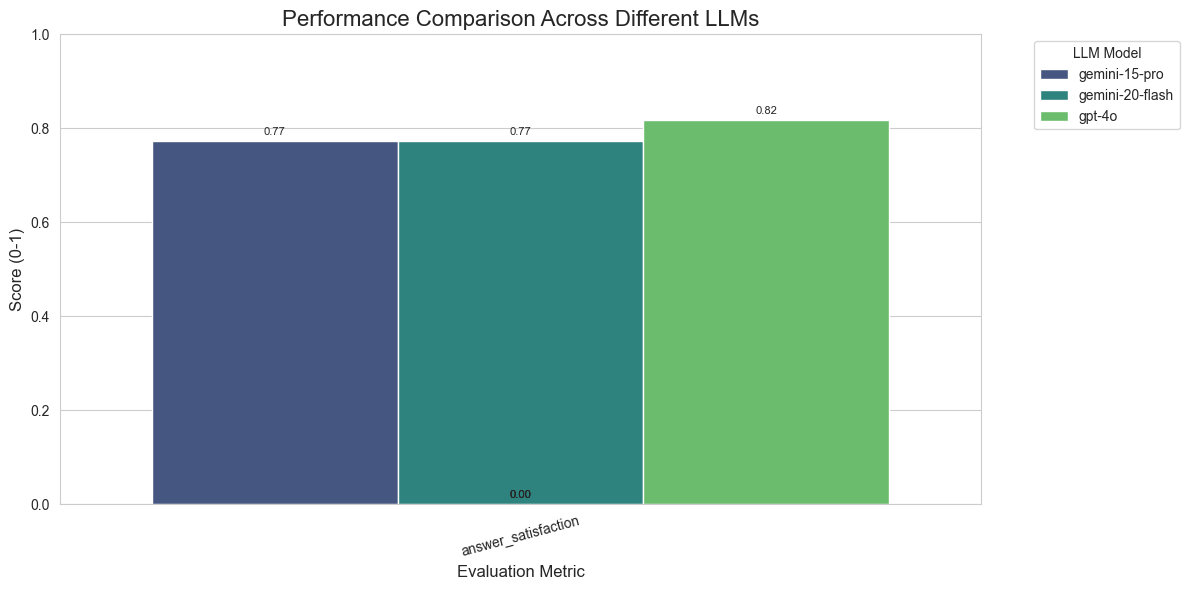

In [13]:
df = pd.DataFrame(evals)

# Reshape the DataFrame for seaborn
df_melted = pd.melt(df, 
                    id_vars=['llm'],
                    value_vars=['answer_satisfaction'],
                    var_name='Metric', 
                    value_name='Score')

# Create a grouped bar chart
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
chart = sns.barplot(x='Metric', y='Score', hue='llm', data=df_melted, palette='viridis')

# Customizing the plot
plt.title('Performance Comparison Across Different LLMs', fontsize=16)
plt.xlabel('Evaluation Metric', fontsize=12)
plt.ylabel('Score (0-1)', fontsize=12)
plt.ylim(0, 1)  # Set y-axis from 0 to 1
plt.xticks(rotation=15)  # Rotate x-axis labels for better readability
plt.legend(title='LLM Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add value labels on top of each bar
for bar in chart.patches:
    chart.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                   ha='center', va='bottom',
                   size=8, xytext=(0, 3),
                   textcoords='offset points')

plt.tight_layout()
plt.show()